In [ ]:
"""
@author: Ajay
"""

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from pyNM.cf_matrix import make_confusion_matrix
from plot_metric.functions import MultiClassClassification
import seaborn as sns
from random import *
get_ipython().run_line_magic('matplotlib', 'inline')
from pyNM.spiking_regressor import *

In [4]:
def run_regressor():
    torch.multiprocessing.freeze_support()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # read house price dataset

    df_house = pd.read_csv('../data/house_price_data.csv')
    print(df_house.shape)
    print(df_house.columns)

    # peek into the data
    print(df_house.head())

    # final dataset

    X = df_house.iloc[:,1:4] # independent attributes
    y = df_house.iloc[:,0] # house price - target
        
    #scaler = StandardScaler()
    #scaler = MinMaxScaler()
    #X_scaled = scaler.fit_transform(X)

    # Create Train — Validation — Test split

    # Train - Test
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

    # Split train into train-val
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=2)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)

    # Scale data to have mean '0' and variance '1' 
    # which is importance for convergence of the neural network
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_val, y_val = np.array(X_val), np.array(y_val)

    X_test, y_test = np.array(X_test), np.array(y_test)   

    # Create & Initialize dataset

    class CreateRegressionDataset(Dataset):
        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__(self):
            return len(self.X_data)

    # create train, val, test dataset

    train_dataset = CreateRegressionDataset(torch.from_numpy(X_train).float(),
                        torch.from_numpy(y_train).float())


    val_dataset = CreateRegressionDataset(torch.from_numpy(X_val).float(),
                            torch.from_numpy(y_val).float())

    test_dataset = CreateRegressionDataset(torch.from_numpy(X_test).float(),
                            torch.from_numpy(y_test).float())

    # define model parameters

    EPOCHS = 150
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001

    NUM_OF_FEATURES = len(X.columns)

    # load the training, validation, and test sets

    print("Loading training, validation, and test data")

    train_loader = DataLoader(dataset=train_dataset,
        batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset,
        batch_size=1)

    test_loader = DataLoader(dataset=test_dataset,
        batch_size=1)


    print("Data loaded...")
    
    # create spiking neural network architecture
    '''
    We will create a feed forward SNN with 3 hidden layers 
    '''
    spiking_model_regressor = SpikingNeuralNetwork(device, X_train.shape[1], hidden_dim_l1=16, hidden_dim_l2=32, hidden_dim_l3=16, n_time_steps=64, begin_eval=0)
    
    print("Model created")
    print(spiking_model_regressor)
    
    # Initialize the model, optimizer, and loss function
    '''
    Transfer the model to GPU/CPU. 
    Here, we use Mean Squared Error (MSE) as loss function
    '''
    
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(spiking_model_regressor.parameters(), lr = LEARNING_RATE)
    print("Optimizer done")

    # dictionary to store loss each epoch for both train & val sets

    loss_stats = {'train': [],
                   'val': []
                    }

    # Train Model

    print("Begin Training...")

    for e in tqdm(range(1, EPOCHS+1)):
        # TRAINING
        train_epoch_loss = 0
        spiking_model_regressor.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            #feed forward
            y_train_pred = spiking_model_regressor(X_train_batch.requires_grad_())
            #calculate the loss
            train_loss = loss_func(y_train_pred, y_train_batch.unsqueeze(1))
            #backward propagation: calculate gradients
            train_loss.backward()
            #update the weights
            optimizer.step()
            #clear out the gradients from the last step loss.backward()
            optimizer.zero_grad()

            train_epoch_loss += train_loss.item()

        # VALIDATION
        with torch.no_grad():
            val_epoch_loss = 0
            spiking_model_regressor.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = spiking_model_regressor(X_val_batch)
                val_loss = loss_func(y_val_pred, y_val_batch.unsqueeze(1))
                val_epoch_loss += val_loss.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))

        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | \
           Val Loss: {val_epoch_loss/len(val_loader): .5f}')


    # Visualize Loss and Accuracy

    #print(loss_stats)
    
    
    #To plot the loss line plots, we will create dataframe
    #from the loss_stats dictionary

    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    plt.figure(figsize=(15,8))
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')


    # Test the performance of the model

    y_pred_list = list()

    with torch.no_grad():
        spiking_model_regressor.eval()
        for X_batch, _ in test_loader:

            X_batch = X_batch.to(device)
            y_test_pred = spiking_model_regressor(X_batch)
            y_pred_list.append(y_test_pred.cpu().numpy()) 

    y_pred_list = [b.squeeze().tolist() for a in y_pred_list for b in a]
    
    #print(y_pred_list)
    #print(y_test)

    #print(len(y_pred_list))

    #print(len(y_test))


    # Lets check widely used regression metrics like MSE, R-squared, RMSE, RMSRE, 

    mse = mean_squared_error(y_test, y_pred_list) # MSE
    r_square = r2_score(y_test, y_pred_list) # R^2
    r = np.corrcoef(y_test, y_pred_list)[0, 1], # r
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_list)), # RMSE
    rmsre = np.sqrt(np.mean(((y_test-y_pred_list)/y_test)**2)), # RMSRE
    mape = np.mean(np.abs((y_test-y_pred_list) / y_test)) * 100 # MAPE

    print("Mean Squared Error:", mse)
    print("R^2 :",r_square)
    print("pcc coefficient", r)
    print("Root Mean Squared Error:", rmse)
    print("Root Mean Squared Relative Error", rmsre)
    print("Mean Absolute Percentage Error", mape)


    # dictionary to store all the metrics

    eval_metrics = {'Mean Squared Error': mse,
                       'R^2': r_square,
                       'pcc coefficient': r,
                       'Root Mean Squared Error':rmse,
                       'Root Mean Squared Relative Error': rmsre,
                       'Mean Absolute Percentage Error': mape
                    }

    #print(eval_metrics)

    # Visualize Metrics as bar plot with sns

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,7))

    sns.barplot(data = pd.DataFrame.from_dict(eval_metrics).melt(), x = "variable", y="value", 
            hue="variable").set_title('Model Peformance on Test set') 


    #eval_metric_df = pd.DataFrame()
    '''
    eval_metric_df = pd.DataFrame((eval_metrics_list), \
                                      columns=['MSE', 'R-Squared','PearsonCorrelationCoefficient',\
                                               'RMSE', 'RMSRE', 'MAPE'])

    print(eval_metric_df)
    '''

    # plot

    #plt.figure(figsize=(6,3))
    #sns.barplot(data=eval_metric_df, x="variable", y="value", hue="variable").set_title('Model Peformance on Test set')
    '''
    plt.plot(log['epoch'], log['loss'], label='Training')
    plt.plot(log['epoch'], log['val_loss'], label='Validation')
    plt.set_title('Loss Plot', fontsize=35)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    '''
    # Install regressormetricgraphplot package from terminal or notebook
    '''
    Terminal: 
    $ pip install regressormetricgraphplot
        OR
    $ git clone https://github.com/ajayarunachalam/RegressorMetricGraphPlot
    $ cd RegressorMetricGraphPlot
    $ python setup.py install
    Notebook:
    !git clone https://github.com/ajayarunachalam/RegressorMetricGraphPlot.git
    cd RegressorMetricGraphPlot/
    Just replace the line 'from CompareModels import *' with 'from regressormetricgraphplot import CompareModels' 
    '''
    # Now, let us check how machine learning algorithms perform on this dataset in comparison to the build neural network
    from regressioncomparemetricplot import CompareModels

    # Linear Regression 

    # Fitting training set to linear regression model
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)

    # Predicting the house price
    y_pred = lr.predict(X_test)

    # Metrics
    print(f'R2_nd_RMSE LR MODEL: {CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_pred)}')

    plot = CompareModels()

    plot.add(model_name='Linear Regression', y_test=y_test, y_pred=y_pred)

    plot.show(figsize=(10, 5))

    # Fitting Random Forest model to the dataset
    rfr = RandomForestRegressor(n_estimators=10, random_state=10, n_jobs=-1)
    rfr.fit(X_train, y_train)

    # Predicting the house price
    y_pred = rfr.predict(X_test)

    print(f'R2_nd_RMSE RF MODEL: {CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_pred)}')

    plot.add('Random Forest', y_test, y_pred)

    plot.show(figsize=(10, 5))

    xgb = XGBRegressor(n_jobs=4, silent=False, objective='reg:linear',
                    max_depth=3, random_state=10, n_estimators=100,
                    learning_rate=0.3, verbose=True)

    xgb.fit(X_train, y_train)

    # Predicting the house price
    y_pred = xgb.predict(X_test)

    print(f'R2_nd_RMSE XGB MODEL: {CompareModels.R2AndRMSE(y_test=y_test, y_pred=y_pred)}')

    plot.add('XGBoost', y_test, y_pred)

    plot.show(figsize=(10, 5))

cpu
(414, 4)
Index(['house_price', 'house_age', 'distance_to_nearest_MRT station',
       'no_of_convenience_stores'],
      dtype='object')
   house_price  house_age  distance_to_nearest_MRT station  \
0         37.9       32.0                         84.87882   
1         42.2       19.5                        306.59470   
2         47.3       13.3                        561.98450   
3         54.8       13.3                        561.98450   
4         43.1        5.0                        390.56840   

   no_of_convenience_stores  
0                        10  
1                         9  
2                         5  
3                         5  
4                         5  
(231, 3)
(231,)
(58, 3)
(58,)
(125, 3)
(125,)
Loading training, validation, and test data
Data loaded...
Model created
SpikingNeuralNetwork(
  (input_conversion): InputDataToSpikingPerceptronLayer()
  (layer1): SpikingNeuronLayer(
    (fc): Linear(in_features=3, out_features=100, bias=True)
  )
  (layer2)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1566.53967 |            Val Loss:  1756.31530
Epoch 002: | Train Loss: 1540.15491 |            Val Loss:  1713.95180
Epoch 003: | Train Loss: 1458.51871 |            Val Loss:  1640.74032
Epoch 004: | Train Loss: 1379.09207 |            Val Loss:  1414.05775
Epoch 005: | Train Loss: 921.87095 |            Val Loss:  236.05281
Epoch 006: | Train Loss: 154.59461 |            Val Loss:  130.85639
Epoch 007: | Train Loss: 136.09735 |            Val Loss:  176.78030
Epoch 008: | Train Loss: 149.27492 |            Val Loss:  195.53264
Epoch 009: | Train Loss: 120.66407 |            Val Loss:  94.58384
Epoch 010: | Train Loss: 103.13349 |            Val Loss:  94.34525
Epoch 011: | Train Loss: 94.54906 |            Val Loss:  85.58343
Epoch 012: | Train Loss: 94.68282 |            Val Loss:  103.05614
Epoch 013: | Train Loss: 93.97477 |            Val Loss:  88.06934
Epoch 014: | Train Loss: 87.72086 |            Val Loss:  80.30201
Epoch 015: | Train Loss: 102.88232 

Epoch 123: | Train Loss: 98.61300 |            Val Loss:  99.89246
Epoch 124: | Train Loss: 64.25112 |            Val Loss:  73.02085
Epoch 125: | Train Loss: 61.96314 |            Val Loss:  106.91275
Epoch 126: | Train Loss: 59.90038 |            Val Loss:  92.27699
Epoch 127: | Train Loss: 56.68209 |            Val Loss:  91.29436
Epoch 128: | Train Loss: 69.19487 |            Val Loss:  115.43612
Epoch 129: | Train Loss: 77.64169 |            Val Loss:  79.76655
Epoch 130: | Train Loss: 64.50627 |            Val Loss:  83.77339
Epoch 131: | Train Loss: 57.90193 |            Val Loss:  89.44370
Epoch 132: | Train Loss: 57.89750 |            Val Loss:  76.44499
Epoch 133: | Train Loss: 55.54608 |            Val Loss:  73.92433
Epoch 134: | Train Loss: 57.74343 |            Val Loss:  76.71786
Epoch 135: | Train Loss: 55.32250 |            Val Loss:  74.65528
Epoch 136: | Train Loss: 69.31677 |            Val Loss:  110.05834
Epoch 137: | Train Loss: 80.03327 |            Val Loss:  7

ModuleNotFoundError: No module named 'regressioncomparemetricplot'

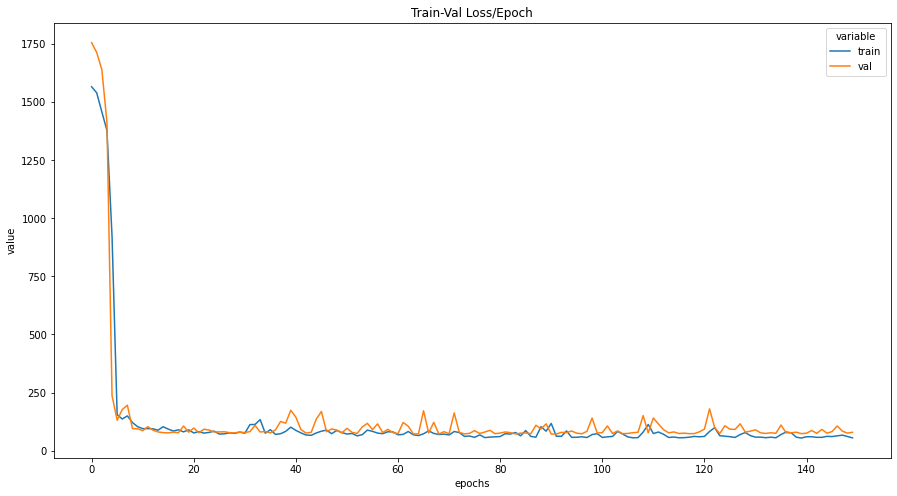

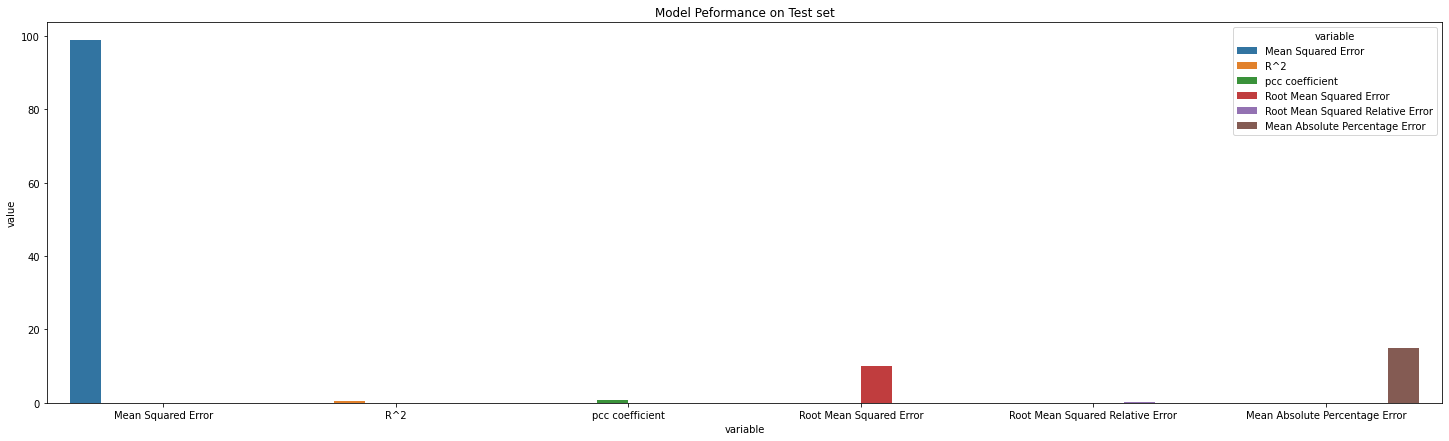

In [5]:
if (__name__ == '__main__'):
    run_regressor()